In [1]:
import numpy as np
import pandas as pd
import pickle

import seaborn as sns

z_dim = 4

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import random
random.seed(41)
np.random.seed(41)

In [4]:
def train(train_data, power):
    X = train_data ** (1 / power)
    mu = np.mean(X, axis=0)
    cov = np.cov(X.T)
    B = np.linalg.cholesky(cov)
    return mu, B, power


def generator(theta, Z):
    mu, B, power = theta
    generated_data = (mu + np.dot(Z, B.T)) ** power
    return generated_data

In [5]:
np.set_printoptions(2)

In [6]:
powers = np.linspace(1, 20, 150)
powers[:5]

array([1.  , 1.13, 1.26, 1.38, 1.51])

In [7]:
train_data = pd.read_csv("./data/train.csv",header=None, index_col=0)
train_data.head()

,1,2,3,4
0,,,,
0,0.012495,0.011126,0.003252,0.006625
1,0.011439,0.002691,0.001206,0.006947
2,0.000632,0.007277,0.004049,0.000074
3,0.017828,0.028210,0.007758,0.007382
4,0.021115,0.019642,0.009238,0.011499


In [8]:
def marginals_anderson_darling(data, generated):
    scores = []
    for k in range(data.shape[1]):
        data_i = data[:, k]
        generated_i = generated[:, k]
        
        n = len(data_i)
        
        concordances = np.array([
            np.sum(
                data_i <= j
            )+1 for j in generated_i
        ])
        
        
        concordances = concordances / (n+2)
        
        error = -n -(1/n) * np.sum([
            (2*i-1) * (np.log(concordances[i-1]) + np.log(1-concordances[n - i])) for i in range(1, n+1)
        ])
        
        scores.append(error)
    return np.mean(scores)

In [9]:
def absolute_kendall_error(data, generated):
    res = 0
    n = data.shape[0] # 410 or 408
    d = data.shape[1] # 4
    for i in range(n):
        data_i = np.concatenate([data[:i], data[(i+1):]])
        generated_i = np.concatenate([generated[:i], generated[(i+1):]])
        
        Zi = np.mean(np.sum(data_i < data[i], axis=1)==d)
        Zti = np.mean(np.sum(generated_i < generated[i], axis=1)==d)
        
        res += abs(Zti - Zi)
    return res/n

In [10]:
eval_set = 0.5

eval_index = int(train_data.shape[0] * (1 - eval_set))
X_train = train_data[: -410]
X_eval = train_data[410:]

In [11]:
import gc
from tqdm import tqdm

In [12]:
scores = []
real_scores = []
zeros = np.zeros(z_dim)
ident = np.eye(z_dim)

tk = tqdm(powers)
for power in tk:
    gc.collect()
    score_p = []
    for i in range(30):
        Z = np.random.multivariate_normal(zeros, ident, X_eval.shape[0])
        generated_data = generator(train(X_train.values, power), Z)
        score1 = absolute_kendall_error(X_eval.values, generated_data)
        score2 = marginals_anderson_darling(X_eval.values, generated_data)
        score_p.append([score1, score2])
    score_p = np.mean(score_p, axis=0)
    score1, score2 = tuple(score_p)
    tk.set_postfix({"power": power, "abs_ken_err": score1, "marg_and":score2})
    scores.append([score1, score2])
    real_scores.append(((1-score1)*1000 + 1000-score2) / 2)

100%|██████████| 150/150 [01:58<00:00,  1.27it/s, power=20, abs_ken_err=0.213, marg_and=365]  


In [13]:
import matplotlib.pyplot as plt

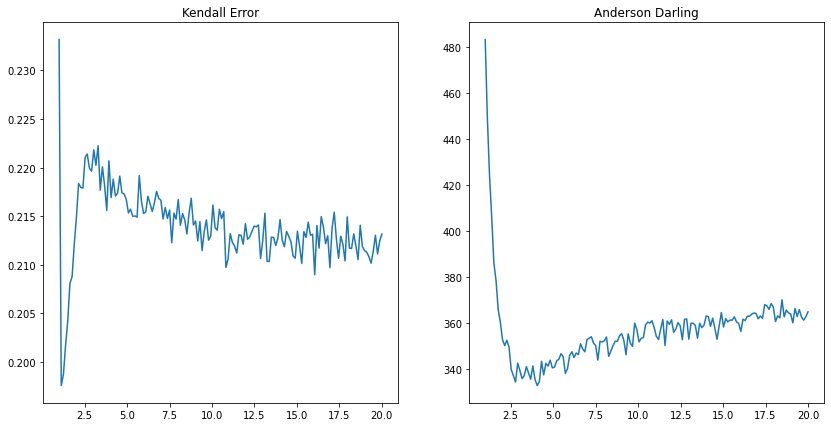

In [14]:
fig = plt.figure(figsize=(14, 7))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.title.set_text('Kendall Error')
ax2.title.set_text('Anderson Darling')
ax1.plot(powers, np.array(scores)[:, 0])
ax2.plot(powers, np.array(scores)[:, 1])
plt.show()

In [15]:
def display_data(fake_data, train_data):
    fake_data = pd.DataFrame(fake_data)
    fake_data.head()

    train_data = pd.DataFrame(train_data)
    train_data.head()

    fake_data["label"] = 1
    train_data["label"] = 0
    
    data = pd.concat([fake_data, train_data])

    sns.pairplot(data, hue='label')

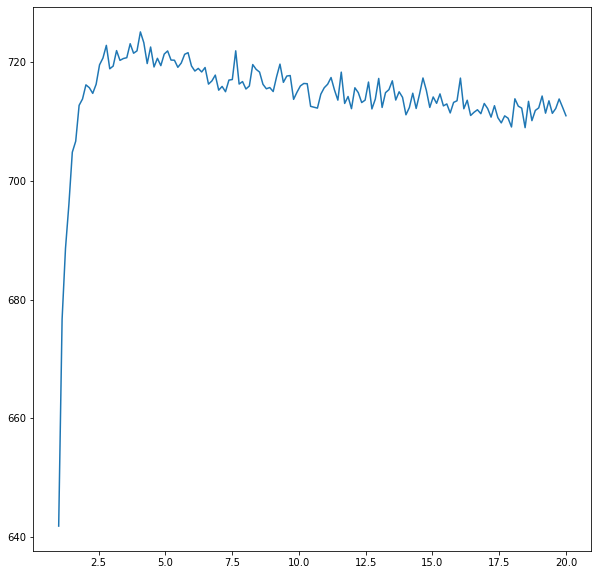

In [17]:
fig = plt.figure(figsize=(10, 10))
plt.plot(powers, real_scores)
plt.show()

In [18]:
max(real_scores)

725.0413638207668

In [25]:
real_scores = np.array(real_scores)
best_power = real_scores > (max(real_scores)-3)
sum(best_power)

5

In [26]:
real_scores[best_power]

array([722.78, 723.05, 725.04, 723.24, 722.5 ])

In [27]:
powers[best_power]

array([2.79, 3.68, 4.06, 4.19, 4.44])

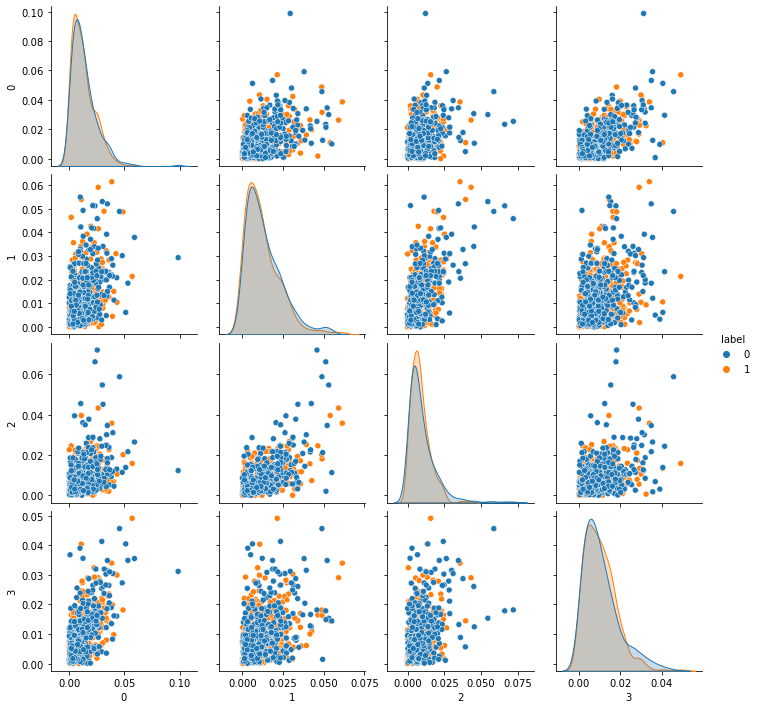

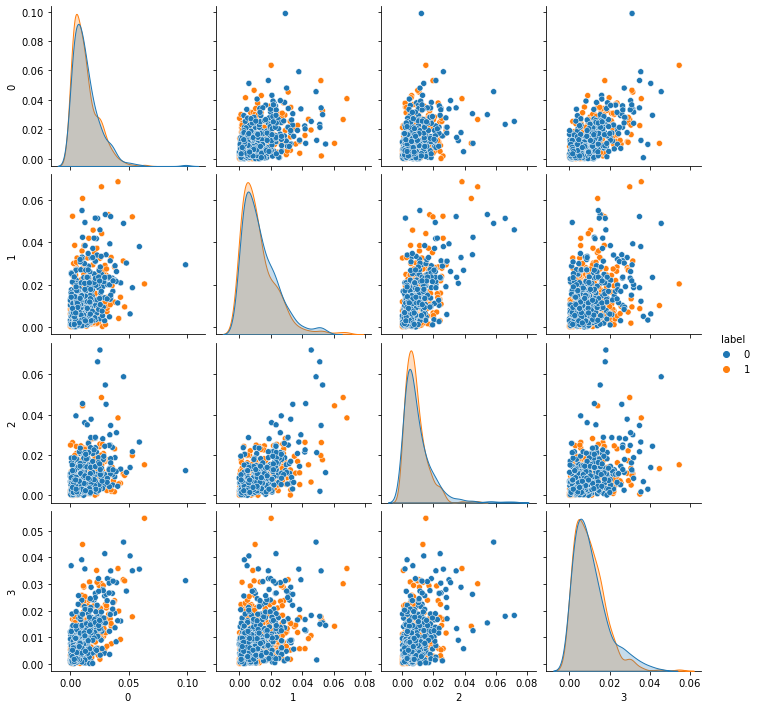

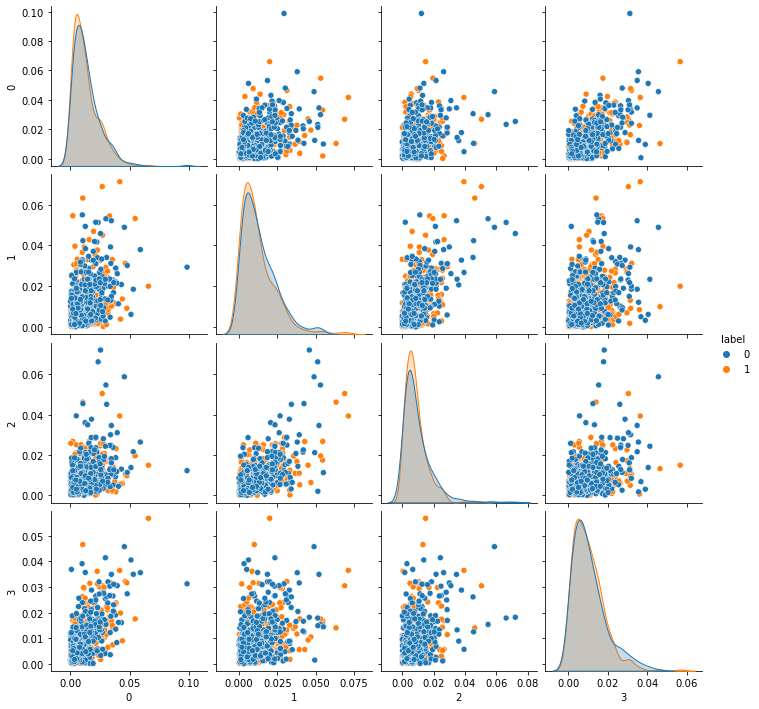

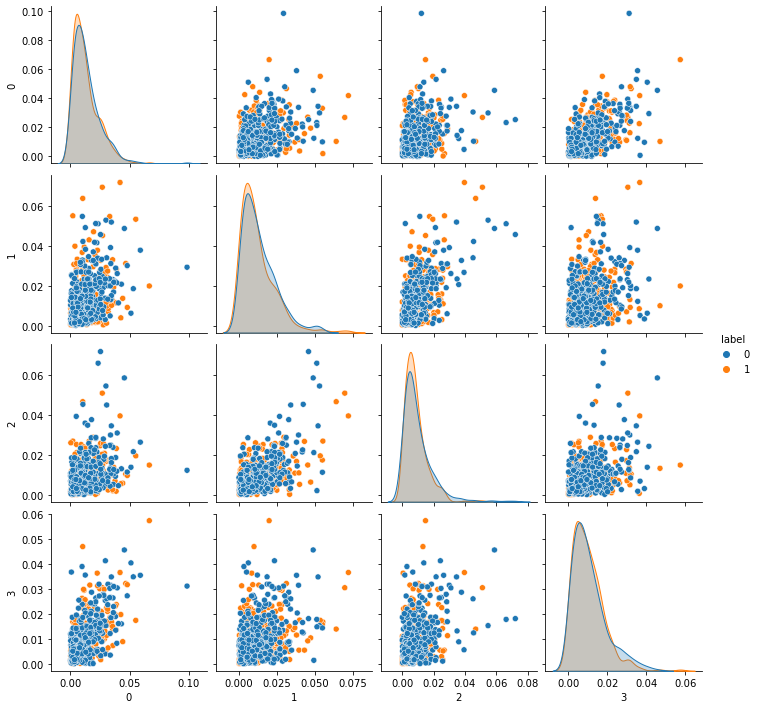

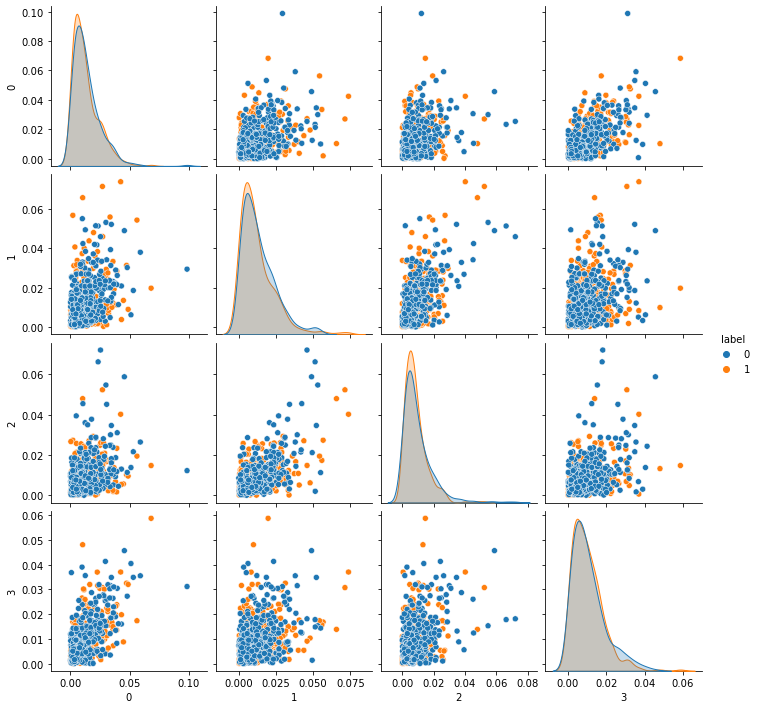

In [29]:
zeros = np.zeros(z_dim)
ident = np.eye(z_dim)
Z = np.random.multivariate_normal(zeros, ident, X_eval.shape[0])

for power in powers[best_power]:
    gc.collect()
    generated_data = generator(train(X_train.values, power), Z)
    display_data(generated_data, X_eval.values)